In [1]:
import numpy as np
import pandas as pd
import os
import zipfile
import cv2
from matplotlib import pyplot as plt
import shutil
from tqdm import tqdm
import torch
import torchvision
import time
import copy
from torchvision import transforms, models

In [2]:
data_root = "plates"

In [4]:
class Remove_background_and_crop:

    def __init__(self,img):
        self.x00 = 0
        self.x00 = 0
        self.r00 = 0
        self.img = img
        self.mask = img

    def crop (self):
            c_r_crop = (1.42*self.r00/2)
            self.img = self.img[int(self.y00)-int(c_r_crop):int(self.y00)+int(c_r_crop),int(self.x00)-int(c_r_crop):int(self.x00)+int(c_r_crop)]
            crop = self.img
            cv2.imwrite(image_folder,crop)
            h,w = self.img.shape[:2]
            c = min(h,w)
            for i in range (5,int(c/3),5):
                    crop_img = self.img[i:h-i,i:w-i]
                    cv2.imwrite(image_folder[:-4] +  '_Crop_' + str(i) + '.jpg',crop_img)
            image1 = self.img[0:int(h//2),0:int(w//2)]

            cv2.imwrite(image_folder[:-4] +  'image1' + '.jpg',image1)
            image2 = self.img[int(h//2):h,int(w//2):w]
            cv2.imwrite(image_folder[:-4] +  'image2' + '.jpg',image2)
            image3 = self.img[int(h//2):h,0:int(w//2)]
            cv2.imwrite(image_folder[:-4] +  'image3' + '.jpg',image3)
            image4 = self.img[0:int(h//2),int(w//2):w]
            cv2.imwrite(image_folder[:-4] +  'image4' + '.jpg',image4)

    def crop_test (self):
        c_r_crop = (1.42*self.r00/2)
        self.img = self.img[int(self.y00)-int(c_r_crop):int(self.y00)+int(c_r_crop),int(self.x00)-int(c_r_crop):int(self.x00)+int(c_r_crop)]
        self.img = cv2.cvtColor(self.img, cv2.COLOR_BGR2RGB)
        cv2.imwrite(image_folder,self.img)

    def find_circle(self):
        output = self.img.copy()
        img = cv2.convertScaleAbs(self.img, alpha=1.2, beta=0.0)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 1, 10,param1=10,param2=5,minRadius=40,maxRadius=250)

        if circles is not None:

            circles = np.round(circles[0, :]).astype("int")

            for x, y, r in circles:
                if ((self.x00-15)<x<(self.x00+15)) and ((self.y00-15)<y<(self.y00+15)):
                    if r > self.r00:
                        self.x00 = x
                        self.y00 = y
                        self.r00 = r

            if self.r00==0:
                ret,thresh = cv2.threshold(self.mask,235,255,0)
                contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_TC89_KCOS)
                c = max(contours, key=cv2.contourArea)
                (self.x00, self.y00), self.r00 = cv2.minEnclosingCircle(c)


    def findCoordinates(self):
        ret,thresh = cv2.threshold(self.mask,235,255,0)
        M = cv2.moments(thresh)
        self.x00 = int(M["m10"] / M["m00"])
        self.y00 = int(M["m01"] / M["m00"])

    def remove_background(self):
        mainRectSize = .08
        fgSize = .01
        img = self.img
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        new_h, new_w = img.shape[:2]
        mask = np.zeros(img.shape[:2], np.uint8)
        bg_w = round(new_w * mainRectSize)
        bg_h = round(new_h * mainRectSize)
        bg_rect = (bg_w, bg_h, new_w - bg_w, new_h - bg_h)
        fg_w = round(new_w * (1 - fgSize) / 2)
        fg_h = round(new_h * (1 - fgSize) / 2)
        fg_rect = (fg_w, fg_h, new_w - fg_w, new_h - fg_h)
        cv2.rectangle(mask, fg_rect[:2], fg_rect[2:4], color=cv2.GC_FGD, thickness=-1)
        bgdModel1 = np.zeros((1, 65), np.float64)
        fgdModel1 = np.zeros((1, 65), np.float64)
        cv2.grabCut(img, mask, bg_rect, bgdModel1, fgdModel1, 3, cv2.GC_INIT_WITH_RECT)
        cv2.rectangle(mask, bg_rect[:2], bg_rect[2:4], color=cv2.GC_PR_BGD, thickness=bg_w * 3)
        cv2.grabCut(img, mask, bg_rect, bgdModel1, fgdModel1, 10, cv2.GC_INIT_WITH_MASK)
        mask_result = np.where((mask == 1) + (mask == 3), 255, 0).astype('uint8')
        masked = cv2.bitwise_and(img, img, mask=mask_result)
        masked[mask_result < 2] = [255, 255, 255]
        self.img = masked
        self.mask = mask_result

for image_index in range (20):
    print ("Complete dirty: ","{0:04}".format(image_index),"/0019", end="\r")
    image_folder = 'plates/train/dirty/{0:04}.jpg'.format(image_index)
    img = cv2.imread(image_folder)
    out_img  = Remove_background_and_crop(img)
    out_img.remove_background()
    out_img.findCoordinates()
    out_img.find_circle()
    out_img.crop()
print ("\n\r", end="")

for image_index in range (20):
    print ("Complete cleaned: ","{0:04}".format(image_index),"/0019", end="\r")
    image_folder = 'plates/train/cleaned/{0:04}.jpg'.format(image_index)
    img = cv2.imread(image_folder)
    out_img  = Remove_background_and_crop(img)
    out_img.remove_background()
    out_img.findCoordinates()
    out_img.find_circle()
    out_img.crop()
print ("\n\r", end="")

for image_index in range (744):
    print ("Complete test: ","{0:04}".format(image_index),"/0743", end="\r")
    image_folder = 'plates/test/{0:04}.jpg'.format(image_index)
    img = cv2.imread(image_folder)
    out_img  = Remove_background_and_crop(img)
    out_img.remove_background()
    out_img.findCoordinates()
    out_img.find_circle()
    out_img.crop_test()
print ("\n\r", end="")

Complete dirty:  0019 /0019
Complete cleaned:  0019 /0019
Complete test:  0743 /0743


In [5]:
train_dir = 'train'
val_dir = 'val'
class_names = ['cleaned', 'dirty']

for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

for class_name in class_names:
    source_dir = os.path.join(data_root, 'train', class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if i % 6 != 0:
            dest_dir = os.path.join(train_dir, class_name)
        else:
            dest_dir = os.path.join(val_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

100%|██████████| 276/276 [00:00<00:00, 302.16it/s]


In [6]:
train_transforms = transforms.Compose([
    transforms.RandomPerspective(distortion_scale=0.09, p=0.75, interpolation=3, fill=255),
    transforms.Resize((224, 224)),
    transforms.ColorJitter(hue=(-0.5,0.5)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.RandomPerspective(distortion_scale=0.1, p=0.8, interpolation=3, fill=255),
    transforms.Resize((224, 224)),
    transforms.ColorJitter(hue=(-0.5,0.5)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

dataset_transforms = {
                      'orig': transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),

                      '140': transforms.Compose([
    transforms.CenterCrop(140),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
                     '135': transforms.Compose([
    transforms.CenterCrop(135),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
                      '130': transforms.Compose([
    transforms.CenterCrop(130),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
                      '125': transforms.Compose([
    transforms.CenterCrop(125),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
                      '120': transforms.Compose([
    transforms.CenterCrop(120),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
                      '115': transforms.Compose([
    transforms.CenterCrop(115),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
                      '110': transforms.Compose([
    transforms.CenterCrop(110),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
                      '105': transforms.Compose([
    transforms.CenterCrop(105),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
                      '100': transforms.Compose([
    transforms.CenterCrop(100),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
                     '95': transforms.Compose([
    transforms.CenterCrop(95),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
                       '90': transforms.Compose([
    transforms.CenterCrop(90),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
                       '85': transforms.Compose([
    transforms.CenterCrop(85),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
                       '80': transforms.Compose([
    transforms.CenterCrop(80),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
                      '75': transforms.Compose([
    transforms.CenterCrop(75),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
                       '70': transforms.Compose([
    transforms.CenterCrop(70),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
                     }

train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)
val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)

batch_size = 16
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)

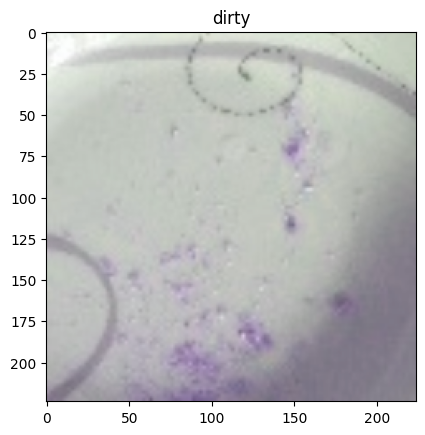

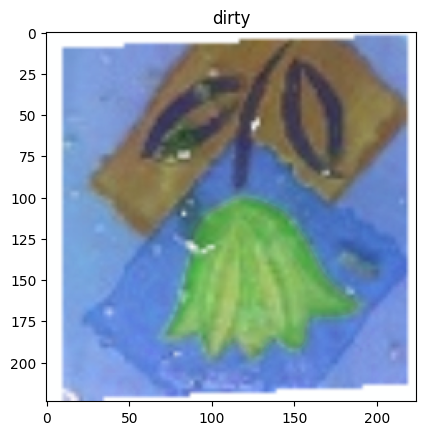

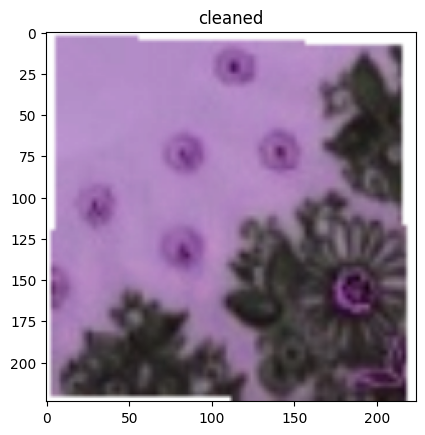

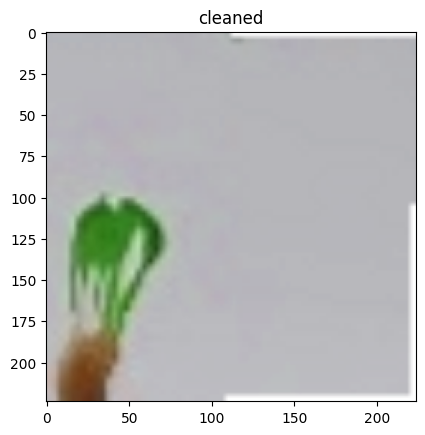

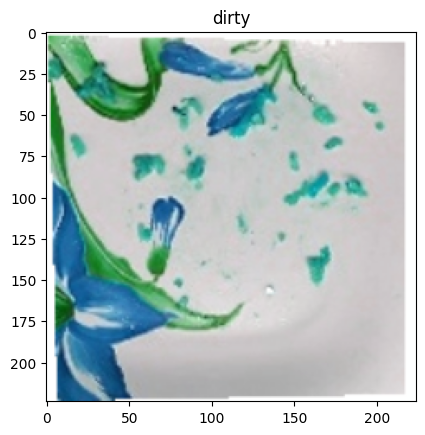

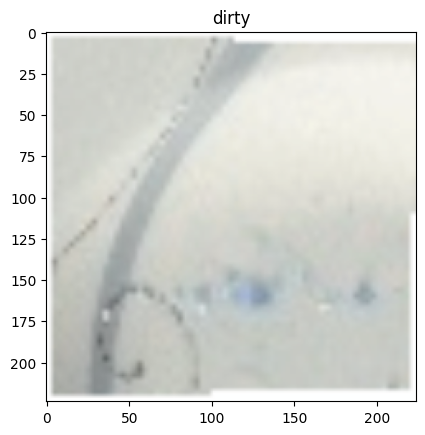

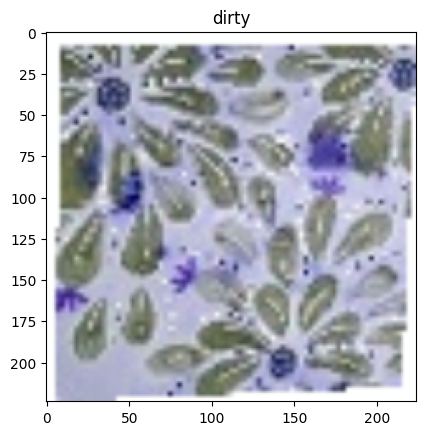

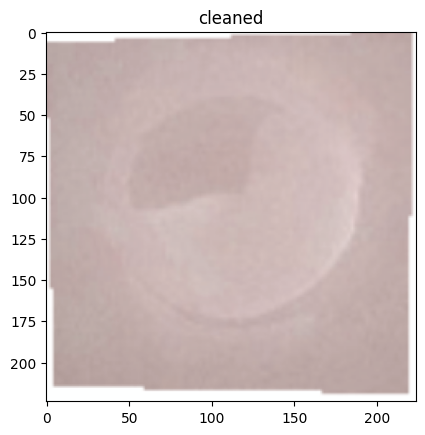

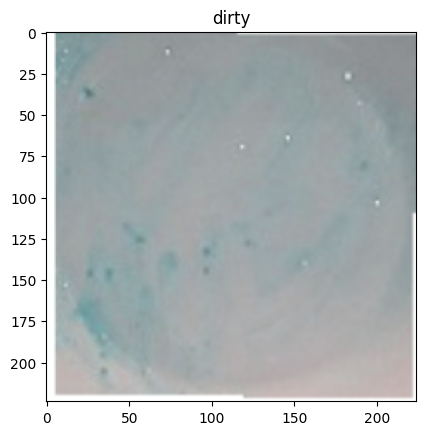

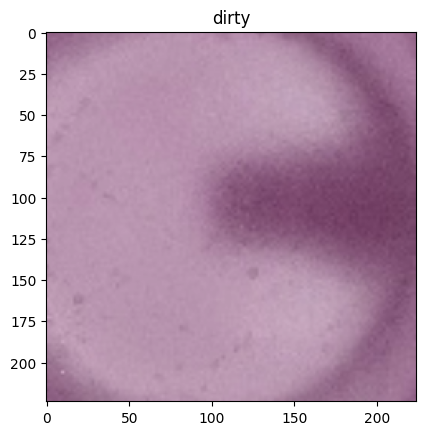

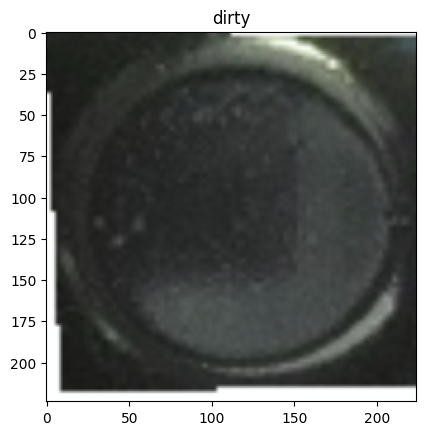

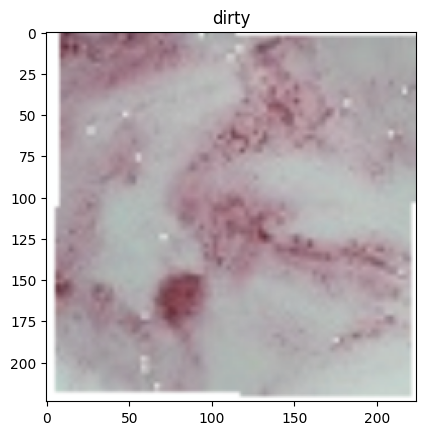

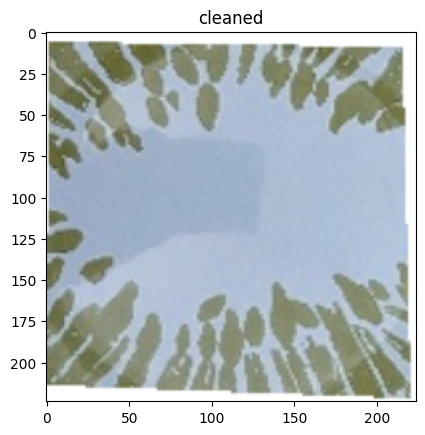

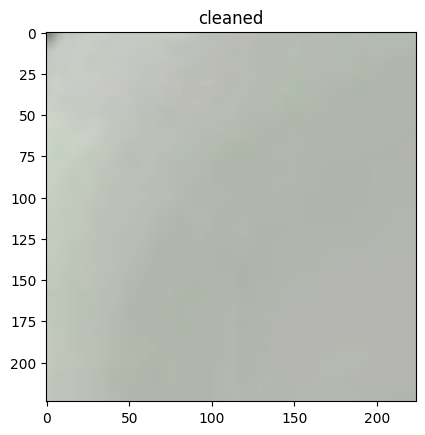

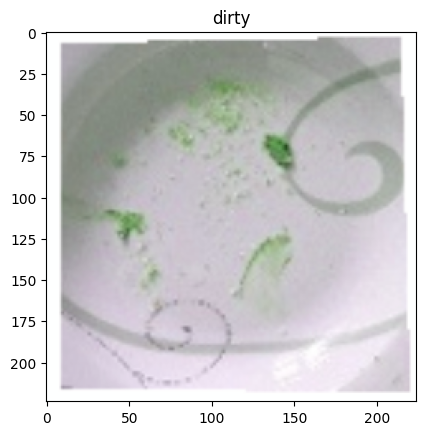

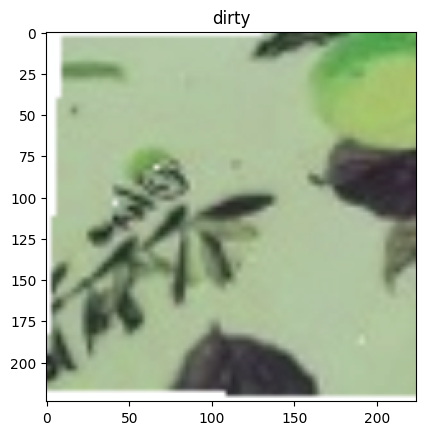

In [7]:
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.1)

X_batch, y_batch = next(iter(train_dataloader))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, title=class_names[y_item])

In [23]:
def train_model(model, loss, optimizer, scheduler, num_epochs):

    loss_hist = {'train':[], 'val':[]}
    acc_hist = {'train':[], 'val':[]}

    for epoch in range(num_epochs):
        print("Epoch {}/{}:".format(epoch, num_epochs - 1), end="")
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step()
                model.train()
            else:
                dataloader = val_dataloader
                model.eval()

            running_loss = 0.
            running_acc = 0.


            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()


                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean().data.cpu().numpy()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)

            print("{} Loss: {:.4f} Acc: {:.4f} ".format(phase, epoch_loss, epoch_acc), end="")

            loss_hist[phase].append(epoch_loss)
            acc_hist[phase].append(epoch_acc)

    return model, loss_hist, acc_hist

In [ ]:
model = models.resnet152(pretrained=True)
for param in model.parameters():
   param.requires_grad = True

model.fc = torch.nn.Linear(model.fc.in_features, 2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), amsgrad=True, lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

c:\Users\alexx\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\alexx\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [41]:
model, loss, acc = train_model(model, loss, optimizer, scheduler, num_epochs=30); #20 best

c:\Users\alexx\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch 0/29:

100%|██████████| 29/29 [00:11<00:00,  2.55it/s]


train Loss: 0.7715 Acc: 0.6501 

100%|██████████| 6/6 [00:05<00:00,  1.02it/s]


val Loss: 29.1059 Acc: 0.5255 Epoch 1/29:

100%|██████████| 29/29 [00:11<00:00,  2.53it/s]


train Loss: 0.5821 Acc: 0.6997 

100%|██████████| 6/6 [00:06<00:00,  1.01s/it]


val Loss: 0.4655 Acc: 0.7859 Epoch 2/29:

100%|██████████| 29/29 [00:11<00:00,  2.53it/s]


train Loss: 0.4483 Acc: 0.8032 

100%|██████████| 6/6 [00:05<00:00,  1.02it/s]


val Loss: 5.0276 Acc: 0.5498 Epoch 3/29:

100%|██████████| 29/29 [00:11<00:00,  2.58it/s]


train Loss: 0.3935 Acc: 0.8132 

100%|██████████| 6/6 [00:06<00:00,  1.03s/it]


val Loss: 0.5110 Acc: 0.7836 Epoch 4/29:

100%|██████████| 29/29 [00:11<00:00,  2.51it/s]


train Loss: 0.3730 Acc: 0.8455 

100%|██████████| 6/6 [00:06<00:00,  1.01s/it]


val Loss: 0.3400 Acc: 0.8356 Epoch 5/29:

100%|██████████| 29/29 [00:11<00:00,  2.54it/s]


train Loss: 0.3619 Acc: 0.8326 

100%|██████████| 6/6 [00:06<00:00,  1.00s/it]


val Loss: 0.6404 Acc: 0.8171 Epoch 6/29:

100%|██████████| 29/29 [00:11<00:00,  2.45it/s]


train Loss: 0.3068 Acc: 0.8678 

100%|██████████| 6/6 [00:06<00:00,  1.01s/it]


val Loss: 0.3307 Acc: 0.8877 Epoch 7/29:

100%|██████████| 29/29 [00:11<00:00,  2.45it/s]


train Loss: 0.2949 Acc: 0.8894 

100%|██████████| 6/6 [00:06<00:00,  1.00s/it]


val Loss: 0.2833 Acc: 0.8877 Epoch 8/29:

100%|██████████| 29/29 [00:11<00:00,  2.55it/s]


train Loss: 0.2315 Acc: 0.9088 

100%|██████████| 6/6 [00:06<00:00,  1.02s/it]


val Loss: 0.2920 Acc: 0.8981 Epoch 9/29:

100%|██████████| 29/29 [00:11<00:00,  2.57it/s]


train Loss: 0.1896 Acc: 0.9246 

100%|██████████| 6/6 [00:06<00:00,  1.01s/it]


val Loss: 0.2587 Acc: 0.8669 Epoch 10/29:

100%|██████████| 29/29 [00:11<00:00,  2.56it/s]


train Loss: 0.1984 Acc: 0.9210 

100%|██████████| 6/6 [00:05<00:00,  1.01it/s]


val Loss: 0.2761 Acc: 0.9190 Epoch 11/29:

100%|██████████| 29/29 [00:11<00:00,  2.55it/s]


train Loss: 0.1743 Acc: 0.9440 

100%|██████████| 6/6 [00:05<00:00,  1.01it/s]


val Loss: 0.2243 Acc: 0.9086 Epoch 12/29:

100%|██████████| 29/29 [00:11<00:00,  2.58it/s]


train Loss: 0.2160 Acc: 0.9174 

100%|██████████| 6/6 [00:06<00:00,  1.00s/it]


val Loss: 0.2252 Acc: 0.8877 Epoch 13/29:

100%|██████████| 29/29 [00:11<00:00,  2.56it/s]


train Loss: 0.1782 Acc: 0.9318 

100%|██████████| 6/6 [00:05<00:00,  1.02it/s]


val Loss: 0.2011 Acc: 0.9190 Epoch 14/29:

100%|██████████| 29/29 [00:11<00:00,  2.54it/s]


train Loss: 0.1401 Acc: 0.9490 

100%|██████████| 6/6 [00:06<00:00,  1.05s/it]


val Loss: 0.2252 Acc: 0.9086 Epoch 15/29:

100%|██████████| 29/29 [00:11<00:00,  2.52it/s]


train Loss: 0.1726 Acc: 0.9361 

100%|██████████| 6/6 [00:06<00:00,  1.04s/it]


val Loss: 0.2338 Acc: 0.9086 Epoch 16/29:

100%|██████████| 29/29 [00:11<00:00,  2.53it/s]


train Loss: 0.2216 Acc: 0.9239 

100%|██████████| 6/6 [00:06<00:00,  1.01s/it]


val Loss: 0.2007 Acc: 0.9190 Epoch 17/29:

100%|██████████| 29/29 [00:11<00:00,  2.54it/s]


train Loss: 0.1505 Acc: 0.9440 

100%|██████████| 6/6 [00:06<00:00,  1.02s/it]


val Loss: 0.2816 Acc: 0.9086 Epoch 18/29:

100%|██████████| 29/29 [00:11<00:00,  2.54it/s]


train Loss: 0.1630 Acc: 0.9382 

100%|██████████| 6/6 [00:05<00:00,  1.00it/s]


val Loss: 0.2020 Acc: 0.9086 Epoch 19/29:

100%|██████████| 29/29 [00:11<00:00,  2.55it/s]


train Loss: 0.1710 Acc: 0.9274 

100%|██████████| 6/6 [00:06<00:00,  1.01s/it]


val Loss: 0.2215 Acc: 0.9190 Epoch 20/29:

100%|██████████| 29/29 [00:11<00:00,  2.54it/s]


train Loss: 0.1257 Acc: 0.9547 

100%|██████████| 6/6 [00:06<00:00,  1.01s/it]


val Loss: 0.2013 Acc: 0.9294 Epoch 21/29:

100%|██████████| 29/29 [00:11<00:00,  2.53it/s]


train Loss: 0.1370 Acc: 0.9526 

100%|██████████| 6/6 [00:06<00:00,  1.00s/it]


val Loss: 0.2137 Acc: 0.9190 Epoch 22/29:

100%|██████████| 29/29 [00:11<00:00,  2.54it/s]


train Loss: 0.1484 Acc: 0.9267 

100%|██████████| 6/6 [00:06<00:00,  1.01s/it]


val Loss: 0.1593 Acc: 0.8981 Epoch 23/29:

100%|██████████| 29/29 [00:11<00:00,  2.54it/s]


train Loss: 0.1426 Acc: 0.9504 

100%|██████████| 6/6 [00:06<00:00,  1.03s/it]


val Loss: 0.1740 Acc: 0.9398 Epoch 24/29:

100%|██████████| 29/29 [00:11<00:00,  2.57it/s]


train Loss: 0.1957 Acc: 0.9203 

100%|██████████| 6/6 [00:06<00:00,  1.02s/it]


val Loss: 0.2391 Acc: 0.9190 Epoch 25/29:

100%|██████████| 29/29 [00:11<00:00,  2.59it/s]


train Loss: 0.1307 Acc: 0.9425 

100%|██████████| 6/6 [00:06<00:00,  1.06s/it]


val Loss: 0.1874 Acc: 0.9294 Epoch 26/29:

100%|██████████| 29/29 [00:11<00:00,  2.47it/s]


train Loss: 0.1204 Acc: 0.9526 

100%|██████████| 6/6 [00:05<00:00,  1.00it/s]


val Loss: 0.2120 Acc: 0.9190 Epoch 27/29:

100%|██████████| 29/29 [00:11<00:00,  2.60it/s]


train Loss: 0.1270 Acc: 0.9504 

100%|██████████| 6/6 [00:06<00:00,  1.01s/it]


val Loss: 0.2070 Acc: 0.9086 Epoch 28/29:

100%|██████████| 29/29 [00:11<00:00,  2.49it/s]


train Loss: 0.1263 Acc: 0.9547 

100%|██████████| 6/6 [00:06<00:00,  1.08s/it]


val Loss: 0.2486 Acc: 0.9086 Epoch 29/29:

100%|██████████| 29/29 [00:11<00:00,  2.42it/s]


train Loss: 0.1256 Acc: 0.9526 

100%|██████████| 6/6 [00:06<00:00,  1.01s/it]

val Loss: 0.2054 Acc: 0.8981 

In [42]:
test_dir = 'test'
shutil.copytree(os.path.join(data_root, 'test'), os.path.join(test_dir, 'unknown'))

'test\\unknown'

In [43]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

df = pd.DataFrame
for (i,tranforms) in dataset_transforms.items():
    test_dataset = ImageFolderWithPaths('test', tranforms)
    test_dataloader = torch.utils.data.DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

    model.eval()
    test_predictions = []
    test_img_paths = []
    for inputs, labels, paths in tqdm(test_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        with torch.set_grad_enabled(False):
            preds = model(inputs)
        test_predictions.append(
            torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
        test_img_paths.extend(paths)
    test_predictions = np.concatenate(test_predictions)


    submission_df = pd.DataFrame.from_dict({'id': test_img_paths, 'label': test_predictions})
    submission_df['id'] = submission_df['id'].str.replace('test/unknown/', '')
    submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
    submission_df.set_index('id', inplace=True)

    try : df = df.merge(submission_df, how='inner', on='id')
    except BaseException:
        df = submission_df
df.head(8)

100%|██████████| 47/47 [00:03<00:00, 12.70it/s]


,label
id,
test\unknown\0000,0.999988
test\unknown\0001,0.994520
test\unknown\0002,0.921769
test\unknown\0003,0.999818
test\unknown\0004,0.998568
test\unknown\0005,0.999649
test\unknown\0006,1.000000
test\unknown\0007,0.993163


In [44]:
df['mean'] = df.mean(axis=1)
df.drop(df.columns[:-1], axis='columns', inplace=True)
df['label'] = df['mean'].map(lambda pred: 'dirty' if pred > 0.50 else 'cleaned')
df.drop(df.columns[:-1], axis='columns', inplace=True)
df.index = df.index.str.replace(r'test\\unknown\\', '', regex=True)
df

,label
id,
0000,dirty
0001,dirty
0002,dirty
0003,dirty
0004,dirty
...,...
0739,dirty
0740,dirty
0741,cleaned


In [45]:
df.to_csv('submission.csv')

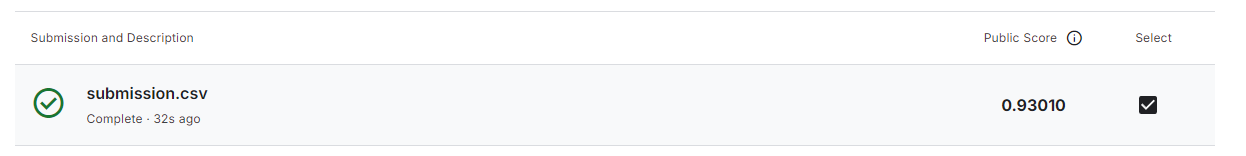